# 

# MCMC and Stan

## Introduction

Welcome back!

Plan for today:

1.  [MCMC](#mcmc)
2.  [Getting started with Stan in
    Python](#getting-started-with-stan-in-python)

## MCMC

### The big picture

**In** A rule for evaluating the target function and maybe its gradients

**Out**: A [**M**arkov
**C**hain](https://en.wikipedia.org/wiki/Markov_chain) of numbers that
you can do [**M**onte
**C**arlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration)
integration with.

### Simple case

#### Problem

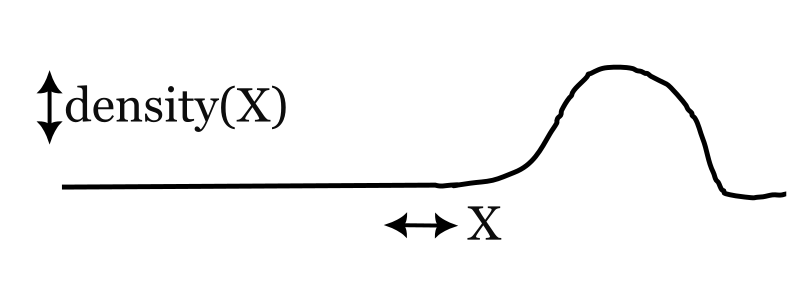

One random variable $X$ with probability density function $density$.

Aka a “one-dimensional parameter space”.

Evaluating $density(x)$ for a given value $x$ (aka “point in parameter
space”) is easy.

Calculating the area under a region of the $density$ curve (aka “the
probability mass”) is expensive.

This is annoying, we need to know that!

#### Solution

Generate a series $x_1, ..., x_i,..., x_n$ where every number depends on
the previous number(s), i.e. a [Markov
chain](https://en.wikipedia.org/wiki/Markov_chain).

To calculate $x_{i+1}$, generate a random number and take into account
$density(x_i)$. [1]

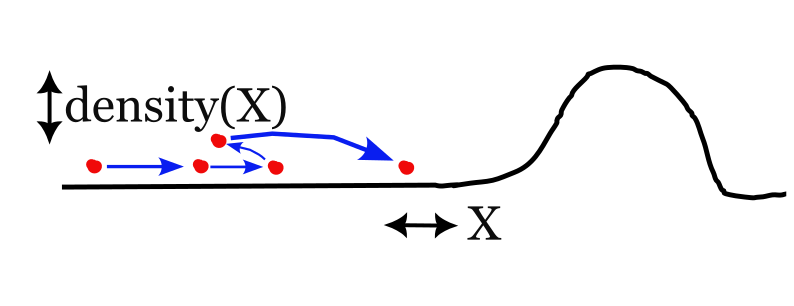

If this works, with a long enough series of numbers we get something
like this:

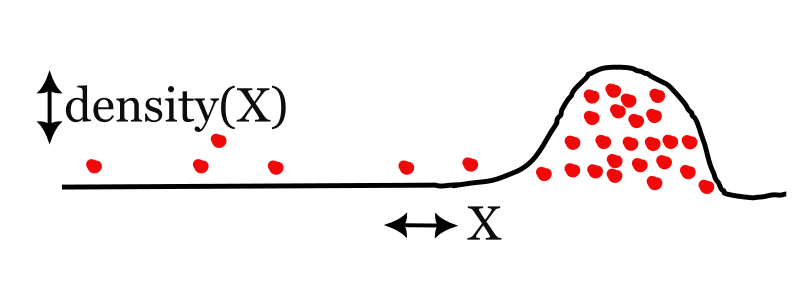

> **Success condition for MCMC**
>
> The numbers from the Markov chain have to approximately agree with the
> target density function, i.e. in any region the number of dots is
> approximately proportional to the area under the curve.

Now we can do [Monte Carlo
integration](https://en.wikipedia.org/wiki/%20Monte_Carlo_integration),
i.e. approximate the area under a region of curve by counting the red
dots in that region.

### Metropolis Hastings

The first (I think?) MCMC algorithm. Original paper: Metropolis et al.
(1953).[2]

Generates Markov chains that provably agree with arbitrary target
density functions (in the asymptotic limit).

Roughly how it works:

1.  Choose candidate by randomly perturbing previous point $x_i$
2.  Accept or reject candidate randomly according to the ratio
    $\frac{density(candidate)}{density(x_i)}$
3.  $x_{i+1}$ is candidate if accept else x_i

[Visualisation](http://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

Doesn’t work for more than ~10 dimensional parameter spaces.

### Hamiltonian Monte Carlo

Big picture: MCMC that works for large parameter spaces.

Key innovation: travel through parameter space quickly using gradients.

Illustration:

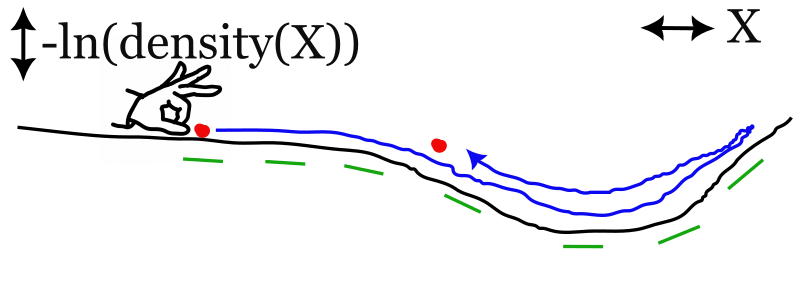

[A better
illustration](http://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=banana)

> **A small but important detail:**
>
> To decide how hard to flick the ball and how precisely to calculate
> its trajectory for a particular case, **adaptation** is required,
> i.e. running the algorithm in warm-up mode for a bit and learning by
> trial and error. How best to do adaptation is an important open
> question.

Limitations:

-   No discrete parameters
-   Performs badly when the target (log-scale) density function is
    wiggly.

#### Reading

Betancourt (2018b)

Betancourt (2018a)

Beskos et al. (2010)

Andrieu and Andrieu (2003)

## Stan

Stan is:

-   A [language](https://mc-stan.org/docs/reference-manual/index.html)
    for specifying probability density functions as Stan programs.

-   A [compiler](https://github.com/stan-dev/stanc3/) that turns Stan
    programs into instructions for inference engines.

-   An [inference engine](https://github.com/stan-dev/stan) implementing
    adaptive HMC and some other algorithms.

-   A [library](https://github.com/stan-dev/math) of functions for
    calculating the gradients of interesting probability density
    functions.

-   Some interfaces for popular computer tools:

    -   Command line:
        [cmdstan](https://mc-stan.org/docs/cmdstan-guide/index.html)
    -   Python:
        -   [cmdstanpy](https://cmdstanpy.readthedocs.io)
        -   [pystan](https://pystan.readthedocs.io/en/latest/)
    -   R:
        -   [cmdstanr](https://mc-stan.org/cmdstanr/)
        -   [Rstan](https://mc-stan.org/users/interfaces/rstan)

### Why use Stan?

Alternatives: [pymc](https://www.pymc.io/welcome.html),
[blackjax](https://blackjax-devs.github.io/blackjax/),
[Turing.jl](https://turinglang.org/stable/) [tensorflow
probability](https://www.tensorflow.org/probability)

Overview as of 2023: Štrumbelj et al. (2023).

Why I like Stan:

-   Big, active and knowledgeable community (most important reason)

-   Featureful (complex numbers, fast solvers, up-to-date diagnostics)

-   Fast (for CPU-bound, general purpose adaptive HMC)

## Getting started with Stan in Python

Install cmdstanpy

``` sh
pip install cmdstanpy
```

Use cmdstanpy to install the rest of Stan

``` sh
python -m cmdstanpy.install_cmdstan --cores 2
```

I like to store Stan outputs using the library arviz. It also makes nice
plots.

``` sh
pip install arviz
```

### Write a Stan program

A Stan program consists of function definitions, variable declarations
and statements, organised into `{...}` delimited blocks, e.g.

``` stan
data {
  real y;  # a variable declaration
}
model {
  y ~ normal(0, 1.4);  # a statement
}
```

The purpose of a Stan program is to define the probability density for
any combination of data and parameters.

It is ok for there to be no parameters:

``` stan
transformed data {
  real y = 2;  # this is both a statement and a declaration!
}
model {
  y ~ normal(0, 1.4);  # the total density is N(2 | 0, 1.4) = 0.103
}
```

or no data:

``` stan
parameters {
  real alpha;
}
model {
  alpha ~ normal(0, 1.4);  # Stan can find the density for any alpha
}
```

### Cmdstanpy workflow

#### Step 1

Use standard Python tools to make a dictionary mapping data variables to
inputs e.g.

``` python
my_stan_input = {"y": 2}
```

(Optional) Save the input as a json file:

``` python
import json
with open("my_stan_input.json", "w") as f:
    json.dump(my_stan_input, f)
```

#### Step 2

Instantiate a `CmdstanModel`

``` python
from cmdstanpy import CmdStanModel
my_model = CmdStanModel(stan_file="my_stan_program.stan")
```

Cmdstanpy will use Stan’s compiler to create `.hpp` and executable
files.

#### Step 3

Use the method `CmdStanModel.sample` to trigger adaptive HMC.

``` python
my_mcmc_results = my_model.sample(data=my_stan_input)
```

#### Step 4

Use the methods `CmdStanMCMC.diagnose` and `CmdStanMCMC.summary` for
quick diagnostics.

``` python
summary = my_mcmc_results.summary()
diagnostics = my_mcmc_results.diagnose()
```

#### Step 5

Convert to arviz `InferenceData` and save

``` python
import arviz
my_idata = arviz.from_cmdstanpy(my_mcmc_results)
my_idata.to_json("my_arviz_idata.json")
```

### Stan references

[Cmdstanpy docs](https://cmdstanpy.readthedocs.io/en/v1.1.0/)

[Stan reference
manual](https://mc-stan.org/docs/reference-manual/index.html)

[Stan functions
reference](https://mc-stan.org/docs/functions-reference/index.html)

[Stan User’s
guide](https://mc-stan.org/docs/stan-users-guide/index.html)

[stan-dev github organisation](https://github.com/stan-dev/)

# Next time / homework

-   How to Program your own mcmc!

-   I ran MCMC, now what??

# References

Andrieu, Christophe, and C Andrieu. 2003. “An Introduction to MCMC for
Machine Learning.”

Beskos, Alexandros, Natesh S. Pillai, Gareth O. Roberts, Jesus M.
Sanz-Serna, and Andrew M. Stuart. 2010. “Optimal Tuning of the Hybrid
Monte-Carlo Algorithm.” arXiv.
<https://doi.org/10.48550/arXiv.1001.4460>.

Betancourt, Michael. 2018a. “The Convergence of Markov Chain Monte Carlo
Methods: From the Metropolis Method to Hamiltonian Monte Carlo.” arXiv.
<https://doi.org/10.48550/arXiv.1706.01520>.

———. 2018b. “A Conceptual Introduction to Hamiltonian Monte Carlo.”
*arXiv:1701.02434 \[Stat\]*, July. <http://arxiv.org/abs/1701.02434>.

Metropolis, Nicholas, Arianna W. Rosenbluth, Marshall N. Rosenbluth,
Augusta H. Teller, and Edward Teller. 1953. “Equation of State
Calculations by Fast Computing Machines.” *The Journal of Chemical
Physics* 21 (6): 1087–92. <https://doi.org/10.1063/1.1699114>.

Štrumbelj, Erik, Alexandre Bouchard-Côté, Jukka Corander, Andrew Gelman,
Håvard Rue, Lawrence Murray, Henri Pesonen, Martyn Plummer, and Aki
Vehtari. 2023. “Past, Present, and Future of Software for Bayesian
Inference.”

[1] This is the interesting and tricky bit!

[2] Metropolis was first author but didn’t do any work! That was
[Arianna
Rosenbluth](https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth)
(programming) plus [Marshall
Rosenbluth](https://en.wikipedia.org/wiki/Marshall_Rosenbluth) & [Edward
Teller](https://en.wikipedia.org/wiki/Edward_Teller) (maths)